In [1]:
1# Configuration - Request Farm Name

# Request farm name from user
FARM_NAME = "Anameka"

# Base directory for KML files
BASE_DIR = r"C:\Users\ibian\Desktop\ClimAdapt\CMIP6\kml files"

# Construct KML file path
# Try common KML file naming patterns
from pathlib import Path
kml_file_path = None

# Try different possible file names
possible_names = [
    f"{FARM_NAME}.kml",
    f"{FARM_NAME}_Farms.kml",
    f"{FARM_NAME}_Farm.kml",
    f"PROJ*_{FARM_NAME}*.kml"  # Pattern matching
]

kml_dir = Path(BASE_DIR) / FARM_NAME
if not kml_dir.exists():
    # If folder doesn't exist, try looking for file directly in base directory
    kml_dir = Path(BASE_DIR)

# Try to find the KML file
for name_pattern in possible_names:
    if '*' in name_pattern:
        # Use glob for pattern matching
        matches = list(kml_dir.glob(name_pattern))
        if matches:
            kml_file_path = matches[0]
            break
    else:
        # Direct file name
        potential_path = kml_dir / name_pattern
        if potential_path.exists():
            kml_file_path = potential_path
            break

if kml_file_path is None or not kml_file_path.exists():
    print(f"⚠️ Warning: KML file not found in {kml_dir}")
    print(f"Attempted file names: {possible_names[:3]}")
    print(f"Please check the file path and ensure the KML file exists.")
    # Ask user to provide full path if file not found
    user_path = input("Enter the full path to the KML file (or press Enter to continue anyway): ").strip()
    if user_path:
        kml_file_path = Path(user_path)
else:
    print(f"✅ Found KML file: {kml_file_path}")

# Store the path for use in next cells
KML_FILE_PATH = str(kml_file_path) if kml_file_path else None

✅ Found KML file: C:\Users\ibian\Desktop\ClimAdapt\CMIP6\kml files\Anameka\PROJ0025_GIS_Anameka_Farms.kml


In [2]:
2# Call functions to perform Operations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import xarray as xr
import glob
from scipy import stats
from scipy.stats import linregress
from pathlib import Path
import xml.etree.ElementTree as ET
from io import StringIO

In [3]:
3# Read the KML file from local path and parse it

from pathlib import Path

# Use the KML file path from configuration
if 'KML_FILE_PATH' not in globals() or KML_FILE_PATH is None:
    raise RuntimeError("KML_FILE_PATH not found. Please run the configuration cell first to set up the farm name and file path.")

kml_path = Path(KML_FILE_PATH)

# Check if file exists
if not kml_path.exists():
    raise FileNotFoundError(f"KML file not found at: {KML_FILE_PATH}\nPlease check the file path and ensure the file exists.")

# Read the KML file content from local path
try:
    with open(kml_path, 'r', encoding='utf-8') as f:
        kml_content = f.read()
    print(f"✅ KML file loaded from: {kml_path}")
except Exception as e:
    raise RuntimeError(f"Error reading KML file: {e}")

# Parse the KML content using ElementTree
kml_tree = ET.ElementTree(ET.fromstring(kml_content))
kml_root = kml_tree.getroot()

print("KML file parsed successfully.")

✅ KML file loaded from: C:\Users\ibian\Desktop\ClimAdapt\CMIP6\kml files\Anameka\PROJ0025_GIS_Anameka_Farms.kml
KML file parsed successfully.


In [4]:
4# Extract farm middle point coordinate from the KML file
from shapely.geometry import Polygon, Point
import warnings

# Find all Polygon coordinates in the KML (assuming standard KML structure)
namespaces = {'kml': 'http://www.opengis.net/kml/2.2'}
coords_list = []
for placemark in kml_root.findall('.//kml:Placemark', namespaces):
    polygon = placemark.find('.//kml:Polygon', namespaces)
    if polygon is not None:
        coords = polygon.find('.//kml:coordinates', namespaces)
        if coords is not None and coords.text:
            # Coordinates are in the form: lon,lat[,alt] separated by spaces or newlines
            coord_pairs = [c.strip() for c in coords.text.replace('\n', ' ').split() if c.strip()]
            try:
                points = [tuple(map(float, c.split(',')[:2])) for c in coord_pairs]
                if len(points) >= 3:  # Valid polygon needs at least 3 points
                    coords_list.append(points)
            except Exception as e:
                warnings.warn(f"Error parsing coordinates: {e}")

if coords_list:
    # Use the first polygon found (or loop for all if needed)
    poly = Polygon(coords_list[0])
    if poly.is_valid and not poly.is_empty:
        centroid = poly.centroid
        middle_point = (centroid.x, centroid.y)
        print(f"Farm middle point coordinate: {middle_point}")
    else:
        print("Polygon is invalid or empty.")
else:
    print("No polygon coordinates found in the KML.")

Farm middle point coordinate: (117.66263846366665, -31.744267057666633)


In [5]:
5# Connect to SILO API Client 
class SILOWeatherAPI:
    def __init__(self, username: str, password: str):
        self.username = username
        self.password = password
        self.api_base_url = "https://www.longpaddock.qld.gov.au/cgi-bin/silo"

    def get_silo_data(self, lat: float, lon: float, start_year: int, end_year: int, format: str = "fao56"):
        import urllib.parse
        import urllib.request
        
        # Correct SILO API parameters
        params = {
            'format': "fao56" if format == "fao56" else "daily",
            'lat': str(round(lat, 4)),
            'lon': str(round(lon, 4)),
            'start': f"{start_year}0101",
            'finish': f"{end_year}1231",
            'username': self.username,
            'password': self.password
        }
        
        # Use correct SILO endpoint
        url = f"{self.api_base_url}/DataDrillDataset.php?" + urllib.parse.urlencode(params)
        
        print(f"🔄 Fetching data for Point ({lat:.4f}, {lon:.4f})...")
        print(f"📡 URL: {url}")
        
        try:
            with urllib.request.urlopen(url, timeout=30) as response:
                data = response.read().decode('utf-8')
                
            # Check if we got valid data
            if "Date" in data and len(data) > 100:
                # Process the SILO format
                lines = data.strip().split('\n')
                
                # Find data start (skip header lines)
                data_start = None
                for i, line in enumerate(lines):
                    if not line.startswith('"') and not line.startswith('!') and line.strip():
                        parts = line.split()
                        if len(parts) >= 3:
                            data_start = i
                            break
                
                if data_start is not None:
                    data_lines = lines[data_start:]
                    df = pd.read_csv(StringIO('\n'.join(data_lines)), delim_whitespace=True)
                    
                    # Clean the data
                    if 'Date' in df.columns:
                        df = df[df['Date'] != '(yyyymmdd)'].copy()
                        df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
                        
                        # Convert numeric columns
                        for col in df.columns:
                            if col != 'Date':
                                df[col] = pd.to_numeric(df[col], errors='coerce')
                        
                        print(f"✅ Success! Retrieved {len(df)} days of data")
                        return df
                    else:
                        print(f"❌ No Date column found. Columns: {df.columns.tolist()}")
                        return None
                else:
                    print(f"❌ Could not find data start in response")
                    return None
            else:
                print(f"❌ Invalid response. Response length: {len(data)}")
                print(f"First 200 chars: {data[:200]}")
                return None
                
        except Exception as e:
            print(f"❌ Error fetching data: {e}")
            return None

# Set credentials and parameters 
username = 'ibianchi@arcasustain.com.au'
password = 'password'  # Use your actual SILO password
start_year = 1981
end_year = 2020

# Use the middle point (centroid) extracted earlier
if 'middle_point' in globals():
    mid_lon, mid_lat = middle_point
    print(f"\nFetching SILO data for farm centroid: ({mid_lat:.4f}, {mid_lon:.4f})")
    api = SILOWeatherAPI(username, password)
    test_df = api.get_silo_data(mid_lat, mid_lon, start_year, end_year)
    if test_df is not None and not test_df.empty:
        print(f"✅ SILO API connection successful for centroid. Sample data:")
        print(test_df.head())
    else:
        print(f"❌ SILO API connection failed for centroid.")


Fetching SILO data for farm centroid: (-31.7443, 117.6626)
🔄 Fetching data for Point (-31.7443, 117.6626)...
📡 URL: https://www.longpaddock.qld.gov.au/cgi-bin/silo/DataDrillDataset.php?format=fao56&lat=-31.7443&lon=117.6626&start=19810101&finish=20201231&username=ibianchi%40arcasustain.com.au&password=password


C:\Users\ibian\AppData\Local\Temp\ipykernel_1896\2157906858.py:49: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(StringIO('\n'.join(data_lines)), delim_whitespace=True)


✅ Success! Retrieved 14610 days of data
✅ SILO API connection successful for centroid. Sample data:
        Date  Day  Date2  T.Max  Smx  T.Min  Smn  Rain  Srn  Evap  Sev  Radn  \
1 1981-01-01    1    NaN   32.3   25   14.3   25   0.0   25  11.2   25  31.8   
2 1981-01-02    2    NaN   32.5   25   18.0   25   0.0   25  13.0   25  26.8   
3 1981-01-03    3    NaN   36.8   25   15.7   25   0.0   25  15.2   25  31.2   
4 1981-01-04    4    NaN   30.5   25   21.7   25   0.0   25   5.1   25   8.1   
5 1981-01-05    5    NaN   39.6   25   16.9   25   2.2   25  15.3   25  31.6   

   Ssl    VP  Svp  RHmaxT  RHminT  FAO56  
1   25  12.4   25    25.6    76.1    7.3  
2   25  12.8   25    26.2    62.1    6.9  
3   25  12.5   25    20.1    70.1    8.0  
4   25  12.5   25    28.6    48.2    4.5  
5   25  13.8   25    19.1    71.7    8.6  


In [6]:
6# Load AGDC grid coordinates from CSV file

# Path to AGDC grid coordinates CSV
agdc_csv_path = r"C:\Users\ibian\Desktop\ClimAdapt\CMIP6\AGDC_grid_coordinates.csv"

# Load the CSV file
print(f"Loading AGDC grid coordinates from: {agdc_csv_path}")
try:
    agdc_df = pd.read_csv(agdc_csv_path)
    print(f"✅ Loaded {len(agdc_df)} grid coordinates from CSV")
    print(f"Columns: {agdc_df.columns.tolist()}")
    print(f"First few rows:\n{agdc_df.head()}")
except Exception as e:
    raise FileNotFoundError(f"Error loading AGDC CSV file: {e}\nPlease check the file path.")

# Verify columns
if 'latitude' not in agdc_df.columns or 'longitude' not in agdc_df.columns:
    raise ValueError(f"CSV file must contain 'latitude' and 'longitude' columns. Found: {agdc_df.columns.tolist()}")

# Convert to list of tuples (lon, lat) for consistency with other grid points
# Note: CSV has lat,lon but we store as (lon, lat) to match other coordinates
agdc_all_points = [(float(row['longitude']), float(row['latitude'])) for _, row in agdc_df.iterrows()]

print(f"✅ Converted {len(agdc_all_points)} AGDC coordinates to (lon, lat) format")

# Store all AGDC points for now - filtering will happen in the plotting cell
# after polygons are defined
agdc_grid_points_all = sorted(agdc_all_points, key=lambda x: (x[1], x[0]))

print("✅ AGDC grid points loaded. Will be filtered in plotting cell based on farm polygons.")

Loading AGDC grid coordinates from: C:\Users\ibian\Desktop\ClimAdapt\CMIP6\AGDC_grid_coordinates.csv
✅ Loaded 138351 grid coordinates from CSV
Columns: ['latitude', 'longitude']
First few rows:
   latitude  longitude
0     -35.0     113.00
1     -35.0     113.05
2     -35.0     113.10
3     -35.0     113.15
4     -35.0     113.20
✅ Converted 138351 AGDC coordinates to (lon, lat) format
✅ AGDC grid points loaded. Will be filtered in plotting cell based on farm polygons.


✅ Filtered to 7 AGDC points from CSV overlapping the farm
✅ SILO grids (green): 5
✅ AGDC grids from CSV (blue): 0
✅ Overlapping grids (black): 7

Label Assignment (North to South):
A: (117.55000, -31.45000)
B: (117.47500, -31.47500)
C: (117.52500, -31.47500)
D: (117.45000, -31.50000)
E: (117.42500, -31.52500)
F: (117.40000, -31.55000)
G: (117.45000, -31.55000)
H: (117.50000, -31.55000)
I: (117.45000, -31.60000)
J: (117.57500, -31.67500)
K: (117.62500, -31.72500)
L: (117.60000, -31.75000)


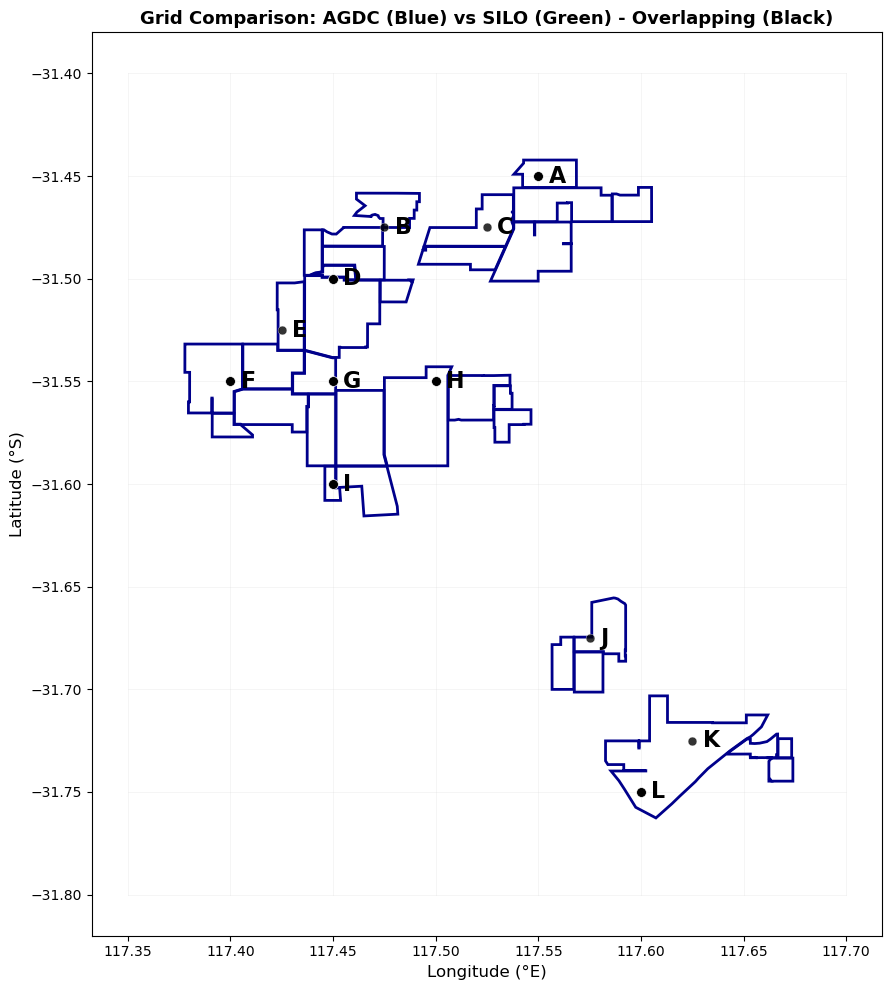


GRID COORDINATES SUMMARY

AGDC grids from CSV - 7 points:
  117.60000, -31.75000
  117.45000, -31.60000
  117.40000, -31.55000
  117.45000, -31.55000
  117.50000, -31.55000
  117.45000, -31.50000
  117.55000, -31.45000

SILO-only grids (green) - 5 points:
  117.62500, -31.72500
  117.57500, -31.67500
  117.42500, -31.52500
  117.47500, -31.47500
  117.52500, -31.47500

Overlapping grids (black) - 7 points:
  117.60000, -31.75000
  117.45000, -31.60000
  117.40000, -31.55000
  117.45000, -31.55000
  117.50000, -31.55000
  117.45000, -31.50000
  117.55000, -31.45000


In [7]:
6# Extract coordinates and Overlay 5‑km Climate Grid on kml file

import xml.etree.ElementTree as ET
import numpy as np
import string
import matplotlib.path as mpath
import matplotlib.pyplot as plt

# ---------- Prerequisite ----------
# Expects `kml_content` string already defined from your earlier KML file reading step.
# The kml_content should be loaded from the local file path in the previous cell.

if 'kml_content' not in globals() or not kml_content:
    raise RuntimeError("kml_content not found. Run the KML file reading cell first to set `kml_content`.")

# ---------- 1) Parse KML ----------
kml_tree = ET.ElementTree(ET.fromstring(kml_content))
kml_root = kml_tree.getroot()

# ---------- 2) AGCD grid parameters ----------
# AGCD (AUS) ~5 km grid reference (lon0, lat0) and step in degrees
lon0, lat0 = 111.975, -44.525
step = 0.05  # degrees ~ 5 km

# ---------- 3) Extract polygons (outer rings only) ----------
# If your KML has holes (innerBoundaryIs), this simple approach ignores holes.
# Add handling if required.
ns = {'kml': 'http://www.opengis.net/kml/2.2'}
polygons = []
for poly_elem in kml_root.findall('.//kml:Polygon', ns):
    coords_el = poly_elem.find('.//kml:outerBoundaryIs/kml:LinearRing/kml:coordinates', ns)
    if coords_el is None or not coords_el.text:
        # fallback to any coordinates node
        coords_el = poly_elem.find('.//kml:coordinates', ns)
    if coords_el is None or not coords_el.text:
        continue
    coords_text = coords_el.text.strip()
    # KML order: lon,lat[,alt]
    coords = []
    for c in coords_text.split():
        parts = c.split(',')[:2]
        try:
            lon, lat = float(parts[0]), float(parts[1])
            coords.append((lon, lat))
        except Exception:
            continue
    if len(coords) >= 3:
        # Ensure ring closed for Path consistency
        if coords[0] != coords[-1]:
            coords.append(coords[0])
        polygons.append(coords)

if not polygons:
    raise ValueError("No polygons extracted from KML. Check structure/namespaces.")

# ---------- 4) Bounding box ----------
all_lons = [lon for poly in polygons for lon, lat in poly]
all_lats = [lat for poly in polygons for lon, lat in poly]
min_lat, max_lat = min(all_lats), max(all_lats)
min_lon, max_lon = min(all_lons), max(all_lons)

# ---------- 5) Select grid points overlapping the farm ----------
poly_paths = [mpath.Path(np.array(poly, dtype=float)) for poly in polygons]
selected_points = set()

# 5a: cell centers
imin_c = int(np.floor((min_lat - lat0) / step - 0.5))
imax_c = int(np.ceil((max_lat - lat0) / step - 0.5))
jmin_c = int(np.floor((min_lon - lon0) / step - 0.5))
jmax_c = int(np.ceil((max_lon - lon0) / step - 0.5))

for i in range(imin_c, imax_c + 1):
    lat_center = lat0 + step * (i + 0.5)
    for j in range(jmin_c, jmax_c + 1):
        lon_center = lon0 + step * (j + 0.5)
        if any(path.contains_point((lon_center, lat_center)) for path in poly_paths):
            selected_points.add((lon_center, lat_center))

# 5b: grid nodes (corners)
imin_n = int(np.floor((min_lat - lat0) / step - 1))
imax_n = int(np.ceil((max_lat - lat0) / step + 1))
jmin_n = int(np.floor((min_lon - lon0) / step - 1))
jmax_n = int(np.ceil((max_lon - lon0) / step + 1))

for i in range(imin_n, imax_n + 1):
    lat_node = lat0 + step * i
    for j in range(jmin_n, jmax_n + 1):
        lon_node = lon0 + step * j
        if any(path.contains_point((lon_node, lat_node)) for path in poly_paths):
            selected_points.add((lon_node, lat_node))

# ---------- 6) Filter AGDC points overlapping the farm ----------
# Filter AGDC points from CSV that overlap with farm polygons
agdc_selected_points = []
if 'agdc_grid_points_all' in globals():
    from shapely.geometry import Point, Polygon as ShapelyPolygon
    
    # Create polygon shapes for intersection testing
    poly_shapes = [ShapelyPolygon(poly) for poly in polygons]
    
    # Filter AGDC points that are within or overlap with farm polygons
    tolerance = 0.001  # Small tolerance for coordinate matching
    for lon, lat in agdc_grid_points_all:
        point = Point(lon, lat)
        # Check if point is within bounding box first (faster)
        if min_lon - tolerance <= lon <= max_lon + tolerance and min_lat - tolerance <= lat <= max_lat + tolerance:
            if any(poly_shape.contains(point) or poly_shape.touches(point) for poly_shape in poly_shapes):
                agdc_selected_points.append((lon, lat))
    
    print(f"✅ Filtered to {len(agdc_selected_points)} AGDC points from CSV overlapping the farm")
else:
    print("⚠️ Warning: AGDC grid points not loaded. Run the AGDC loading cell first.")

# ---------- 7) Identify overlapping points ----------
# Convert to sets for easier comparison
silo_points_set = set((round(lon, 5), round(lat, 5)) for lon, lat in selected_points)
agdc_points_set = set((round(lon, 5), round(lat, 5)) for lon, lat in agdc_selected_points)

# Find overlapping points (same coordinates)
overlapping_points = silo_points_set & agdc_points_set

# Separate SILO-only and AGDC-only points
silo_only_points = [(lon, lat) for lon, lat in selected_points 
                    if (round(lon, 5), round(lat, 5)) not in overlapping_points]
agdc_only_points = [(lon, lat) for lon, lat in agdc_selected_points 
                    if (round(lon, 5), round(lat, 5)) not in overlapping_points]

print(f"✅ SILO grids (green): {len(silo_only_points)}")
print(f"✅ AGDC grids from CSV (blue): {len(agdc_only_points)}")
print(f"✅ Overlapping grids (black): {len(overlapping_points)}")


# Helper function for Excel-style labels
def excel_label(n):
    """Convert 0-based integer n to Excel-style label: 0->A, 1->B, ..., 25->Z, 26->AA, ..."""
    n = n + 1  # convert to 1-based
    s = []
    while n > 0:
        n, r = divmod(n - 1, 26)
        s.append(string.ascii_uppercase[r])
    return ''.join(reversed(s))


# ---------- 8) Plot ----------
fig, ax = plt.subplots(figsize=(10, 10))

# Polygons (farm boundaries from KML)
for poly in polygons:
    xs = [p[0] for p in poly]
    ys = [p[1] for p in poly]
    ax.fill(xs, ys, edgecolor="darkblue", fill=False, linewidth=2, zorder=1)

# Grid lines (for reference)
lat_lines = np.arange(np.floor(min_lat/step)*step, np.ceil(max_lat/step)*step + step, step)
lon_lines = np.arange(np.floor(min_lon/step)*step, np.ceil(max_lon/step)*step + step, step)
for lat in lat_lines:
    ax.plot([lon_lines.min(), lon_lines.max()], [lat, lat], color='lightgray', linewidth=0.5, zorder=0, alpha=0.3)
for lon in lon_lines:
    ax.plot([lon, lon], [lat_lines.min(), lat_lines.max()], color='lightgray', linewidth=0.5, zorder=0, alpha=0.3)


# Collect all points for labeling
all_points_to_label = []
point_labels_map = {}

# Add overlapping points
if overlapping_points:
    for lon, lat in [(lon, lat) for lon, lat in selected_points 
                     if (round(lon, 5), round(lat, 5)) in overlapping_points]:
        all_points_to_label.append((lon, lat))

# Add AGDC-only points
if agdc_only_points:
    for lon, lat in agdc_only_points:
        all_points_to_label.append((lon, lat))

# Add SILO-only points  
if silo_only_points:
    for lon, lat in silo_only_points:
        all_points_to_label.append((lon, lat))

# Sort points and assign labels
sorted_all_points = sorted(all_points_to_label, key=lambda x: (-x[1], x[0]))  # Sort by -lat (north to south), then lon
for i, pt in enumerate(sorted_all_points):
    point_labels_map[pt] = excel_label(i)

# Print label assignment for verification
print("\nLabel Assignment (North to South):")
for pt, label in sorted(point_labels_map.items(), key=lambda x: (-x[0][1], x[0][0])):
    print(f"{label}: ({pt[0]:.5f}, {pt[1]:.5f})")

# Plot overlapping points in BLACK (highest priority)
if overlapping_points:
    overlap_lons, overlap_lats = zip(*[(lon, lat) for lon, lat in selected_points 
                                       if (round(lon, 5), round(lat, 5)) in overlapping_points])
    ax.scatter(overlap_lons, overlap_lats, color='black', s=50, marker='o', zorder=5, 
               edgecolors='white', linewidths=0.5)

    # Add labels to overlapping points
    for lon, lat in [(lon, lat) for lon, lat in selected_points
                     if (round(lon, 5), round(lat, 5)) in overlapping_points]:
        # Find matching point in labels map (handle rounding)
        pt_found = None
        for pt_key in point_labels_map.keys():
            if abs(pt_key[0] - lon) < 0.0001 and abs(pt_key[1] - lat) < 0.0001:
                pt_found = pt_key
                break
        if pt_found:
            ax.text(lon + 0.005, lat, point_labels_map[pt_found], color="black", fontsize=16,
                    ha="left", va="center", fontweight="bold", zorder=6)

# Plot AGDC-only points in BLUE
if agdc_only_points:
    agdc_lons, agdc_lats = zip(*agdc_only_points)
    ax.scatter(agdc_lons, agdc_lats, color='black', s=40, marker='s', zorder=4, 
               edgecolors='white', linewidths=0.3, alpha=0.8)

    # Add labels to AGDC-only points
    for lon, lat in agdc_only_points:
        # Find matching point in labels map (handle rounding)
        pt_found = None
        for pt_key in point_labels_map.keys():
            if abs(pt_key[0] - lon) < 0.0001 and abs(pt_key[1] - lat) < 0.0001:
                pt_found = pt_key
                break
        if pt_found:
            ax.text(lon + 0.005, lat, point_labels_map[pt_found], color="black", fontsize=16,
                    ha="left", va="center", fontweight="bold", zorder=6)

# Plot SILO-only points in GREEN
if silo_only_points:
    silo_lons, silo_lats = zip(*silo_only_points)
    ax.scatter(silo_lons, silo_lats, color='black', s=40, marker='o', zorder=4, 
               edgecolors='white', linewidths=0.3, alpha=0.8)

    # Add labels to SILO-only points
    for lon, lat in silo_only_points:
        # Find matching point in labels map (handle rounding)
        pt_found = None
        for pt_key in point_labels_map.keys():
            if abs(pt_key[0] - lon) < 0.0001 and abs(pt_key[1] - lat) < 0.0001:
                pt_found = pt_key
                break
        if pt_found:
            ax.text(lon + 0.005, lat, point_labels_map[pt_found], color="black", fontsize=16,
                    ha="left", va="center", fontweight="bold", zorder=6)

ax.set_xlabel("Longitude (°E)", fontsize=12)
ax.set_ylabel("Latitude (°S)", fontsize=12)
ax.set_title("Grid Comparison: AGDC (Blue) vs SILO (Green) - Overlapping (Black)", fontsize=13, fontweight='bold')
ax.set_aspect("equal", adjustable="box")
plt.tight_layout()
plt.show()

# ---------- 9) Print grid coordinates summary ----------
print("\n" + "="*60)
print("GRID COORDINATES SUMMARY")
print("="*60)

# Print all AGDC grid coordinates from CSV
if agdc_selected_points:
    print(f"\nAGDC grids from CSV - {len(agdc_selected_points)} points:")
    for lon, lat in sorted(agdc_selected_points, key=lambda x: (x[1], x[0])):
        print(f"  {lon:.5f}, {lat:.5f}")
else:
    print("\nAGDC grids from CSV - 0 points (no AGDC points found)")

print(f"\nSILO-only grids (green) - {len(silo_only_points)} points:")
for lon, lat in sorted(silo_only_points, key=lambda x: (x[1], x[0])):
    print(f"  {lon:.5f}, {lat:.5f}")

if overlapping_points:
    print(f"\nOverlapping grids (black) - {len(overlapping_points)} points:")
    for lon, lat in sorted([(lon, lat) for lon, lat in selected_points 
                           if (round(lon, 5), round(lat, 5)) in overlapping_points], 
                          key=lambda x: (x[1], x[0])):
        print(f"  {lon:.5f}, {lat:.5f}")
print("="*60)

# Make available as a list variable for downstream use
selected_agcd_points = sorted(selected_points, key=lambda x: (x[1], x[0]))

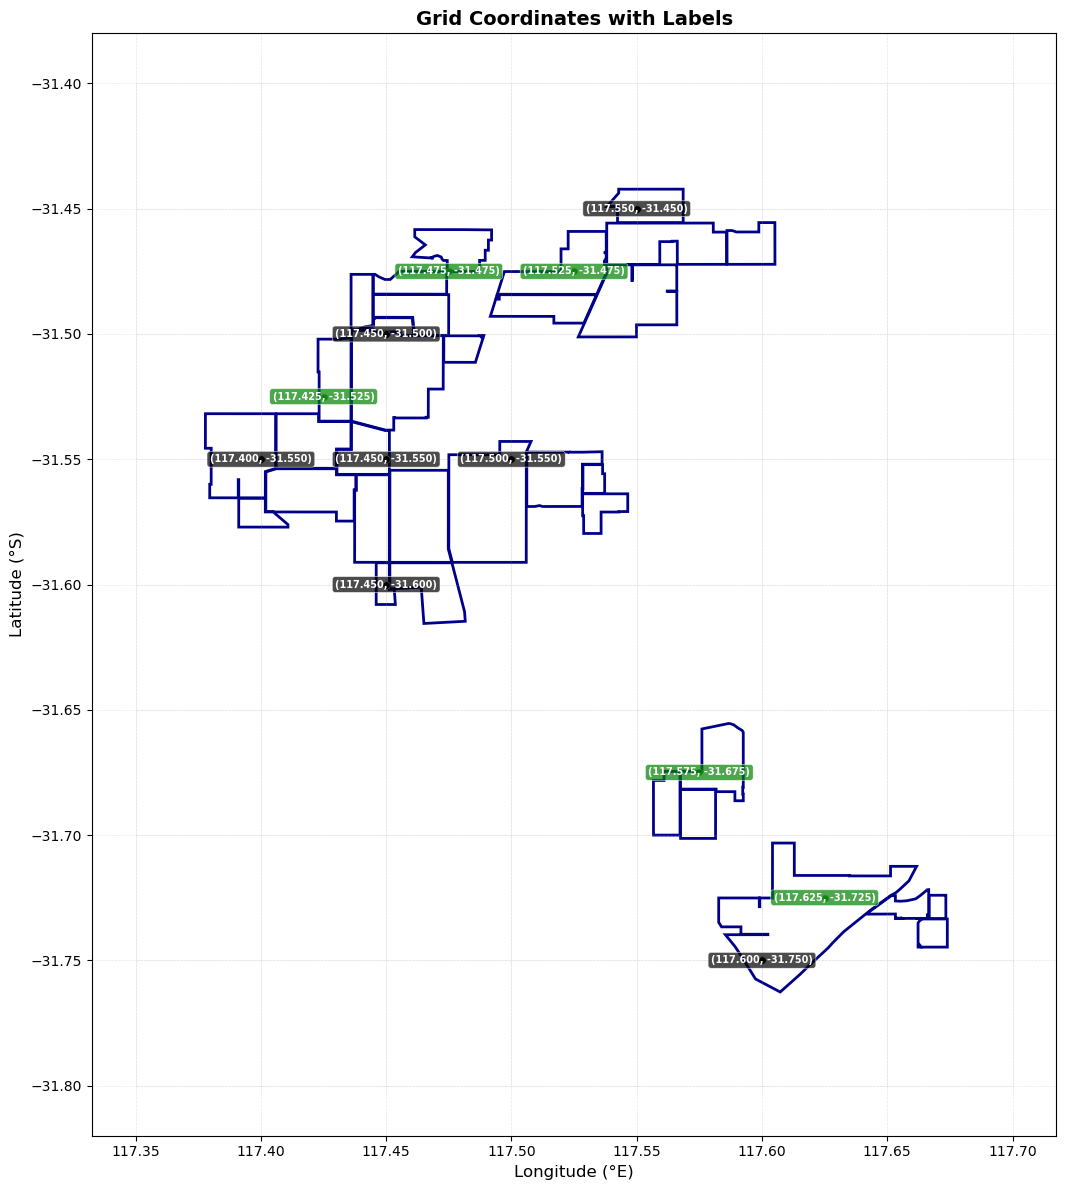

In [8]:
# Plot with coordinates next to each point

import string
import numpy as np
import matplotlib.pyplot as plt

# Helper function for Excel-style labels (for consistency)
def excel_label(n):
    """Convert 0-based integer n to Excel-style label: 0->A, 1->B, ..., 25->Z, 26->AA, ..."""
    n = n + 1
    s = []
    while n > 0:
        n, r = divmod(n - 1, 26)
        s.append(string.ascii_uppercase[r])
    return ''.join(reversed(s))

# Collect all points for labeling
all_points_coords = []

# Add overlapping points
if 'overlapping_points' in globals() and overlapping_points:
    for lon, lat in [(lon, lat) for lon, lat in selected_points 
                     if (round(lon, 5), round(lat, 5)) in overlapping_points]:
        all_points_coords.append((lon, lat))

# Add AGDC-only points
if 'agdc_only_points' in globals() and agdc_only_points:
    for lon, lat in agdc_only_points:
        all_points_coords.append((lon, lat))

# Add SILO-only points
if 'silo_only_points' in globals() and silo_only_points:
    for lon, lat in silo_only_points:
        all_points_coords.append((lon, lat))

# Sort points for consistent ordering
sorted_all_points = sorted(all_points_coords, key=lambda x: (x[1], x[0]))  # Sort by lat, then lon

# Create the plot with coordinates
fig2, ax2 = plt.subplots(figsize=(12, 12))

# Polygons (farm boundaries from KML)
if 'polygons' in globals() and polygons:
    for poly in polygons:
        xs = [p[0] for p in poly]
        ys = [p[1] for p in poly]
        ax2.fill(xs, ys, edgecolor="darkblue", fill=False, linewidth=2, zorder=1)

# Grid lines (for reference)
if 'min_lat' in globals() and 'step' in globals():
    lat_lines = np.arange(np.floor(min_lat/step)*step, np.ceil(max_lat/step)*step + step, step)
    lon_lines = np.arange(np.floor(min_lon/step)*step, np.ceil(max_lon/step)*step + step, step)
    for lat in lat_lines:
        ax2.plot([lon_lines.min(), lon_lines.max()], [lat, lat], color='lightgray', linewidth=0.5, zorder=0, alpha=0.3)
    for lon in lon_lines:
        ax2.plot([lon, lon], [lat_lines.min(), lat_lines.max()], color='lightgray', linewidth=0.5, zorder=0, alpha=0.3)

# Plot overlapping points in BLACK
if 'overlapping_points' in globals() and overlapping_points:
    overlap_lons, overlap_lats = zip(*[(lon, lat) for lon, lat in selected_points 
                                       if (round(lon, 5), round(lat, 5)) in overlapping_points])
    ax2.scatter(overlap_lons, overlap_lats, color='black', s=30, marker='o', zorder=5, 
               edgecolors='white', linewidths=0.5)
    
    # Add coordinate labels to overlapping points
    for lon, lat in [(lon, lat) for lon, lat in selected_points 
                     if (round(lon, 5), round(lat, 5)) in overlapping_points]:
        ax2.text(lon, lat, f'({lon:.3f}, {lat:.3f})', color='white', fontsize=7,
                ha='center', va='center', fontweight='bold', zorder=6,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7, edgecolor='white', linewidth=0.5))

# Plot AGDC-only points in BLUE
if 'agdc_only_points' in globals() and agdc_only_points:
    agdc_lons, agdc_lats = zip(*agdc_only_points)
    ax2.scatter(agdc_lons, agdc_lats, color='blue', s=25, marker='s', zorder=4, 
               edgecolors='white', linewidths=0.3, alpha=0.8)
    
    # Add coordinate labels to AGDC-only points
    for lon, lat in agdc_only_points:
        ax2.text(lon, lat, f'({lon:.3f}, {lat:.3f})', color='white', fontsize=7,
                ha='center', va='center', fontweight='bold', zorder=6,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='blue', alpha=0.7, edgecolor='white', linewidth=0.5))

# Plot SILO-only points in GREEN
if 'silo_only_points' in globals() and silo_only_points:
    silo_lons, silo_lats = zip(*silo_only_points)
    ax2.scatter(silo_lons, silo_lats, color='green', s=25, marker='o', zorder=4, 
               edgecolors='white', linewidths=0.3, alpha=0.8)
    
    # Add coordinate labels to SILO-only points
    for lon, lat in silo_only_points:
        ax2.text(lon, lat, f'({lon:.3f}, {lat:.3f})', color='white', fontsize=7,
                ha='center', va='center', fontweight='bold', zorder=6,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='green', alpha=0.7, edgecolor='white', linewidth=0.5))

ax2.set_xlabel("Longitude (°E)", fontsize=12)
ax2.set_ylabel("Latitude (°S)", fontsize=12)
ax2.set_title("Grid Coordinates with Labels", fontsize=14, fontweight='bold')
ax2.set_aspect("equal", adjustable="box")
ax2.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
